António Mesquita Ferreira, August 2020
_________
We have here a subset of the lending club dataset. This dataset was provided to me by my EDA teacher, João Veiga, at Rumos Pos-graduação Data Science.

The purpose of this is purely educational, I'll apply some knowleage on data exploratory analysis and them run a few machine learning models to try to predict bad loans. 

The dataset consists of various features with informaion about individuals with loans from the Lending Club.

In [239]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

In [240]:
data = pd.read_csv('lending_dataset.csv', low_memory=False)

### Feature description

- **id:** Unique ID of the loan application.
- **grade:** LC assigned loan grade.
- **annual_inc:** The self-reported annual income provided by the borrower during registration.
- **short_emp:** `1` when employed for 1 year or less.
- **emp_length_num:** Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- **home_ownership:** Type of home ownership.
- **dti:** Debt-To-Income Ratio: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- **purpose:** A category provided by the borrower for the loan request. 
- **term:** The number of payments on the loan. Values are in months and can be either 36 or 60.
- **last_delinq_none:** `1` when borrower had at least one event of deliquency.
- **last_major_derog_none:** `1` borrower had at least 90 days of bad rating.
- **revol_util:** Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- **total_rec_late_fee:** Late fees received to date.
- **od_ratio:** Overdraft ratio.
- **bad_loan:** `1` when a loan was not payed.

__________

Let's start with some general view of our data

In [241]:
data.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
id                       20000 non-null int64
grade                    20000 non-null object
annual_inc               20000 non-null float64
short_emp                20000 non-null int64
emp_length_num           20000 non-null int64
home_ownership           18509 non-null object
dti                      19846 non-null float64
purpose                  20000 non-null object
term                     20000 non-null object
last_delinq_none         20000 non-null int64
last_major_derog_none    574 non-null float64
revol_util               20000 non-null float64
total_rec_late_fee       20000 non-null float64
od_ratio                 20000 non-null float64
bad_loan                 20000 non-null int64
dtypes: float64(6), int64(5), object(4)
memory usage: 2.3+ MB


In [243]:
data.describe()

,id,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,2.000000e+04,20000.000000,20000.000000,20000.00000,19846.000000,20000.000000,574.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,7.590662e+06,73349.578350,0.112500,6.82140,16.587841,0.546600,0.759582,55.958148,0.290622,0.504430,0.20000
std,1.609593e+06,45198.567255,0.315989,3.77423,7.585812,0.497836,0.427710,42.117456,3.108654,0.287720,0.40001
min,5.860400e+05,8412.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000077,0.00000
25%,6.206283e+06,47000.000000,0.000000,3.00000,10.852500,0.000000,1.000000,38.800000,0.000000,0.257356,0.00000
50%,7.378896e+06,65000.000000,0.000000,7.00000,16.190000,1.000000,1.000000,57.100000,0.000000,0.506681,0.00000
75%,8.766235e+06,88000.000000,0.000000,11.00000,22.060000,1.000000,1.000000,73.900000,0.000000,0.753771,0.00000
max,1.145464e+07,1000000.000000,1.000000,11.00000,34.990000,1.000000,1.000000,5010.000000,96.466600,0.999894,1.00000


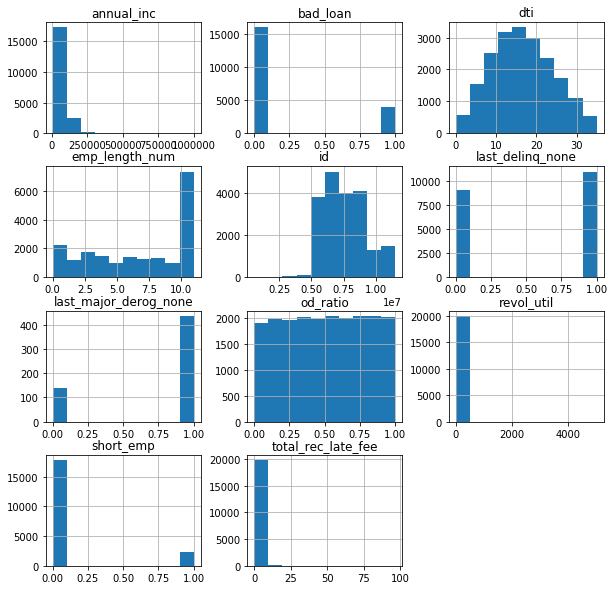

In [245]:
data.hist(figsize=(10,10));

Let's also look at the distribution of our categorical features. Since we have only 4 let's do 4 plot bars

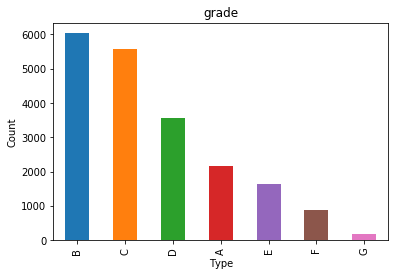

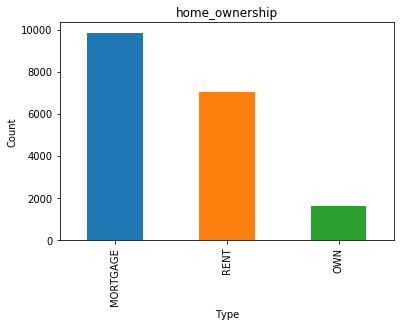

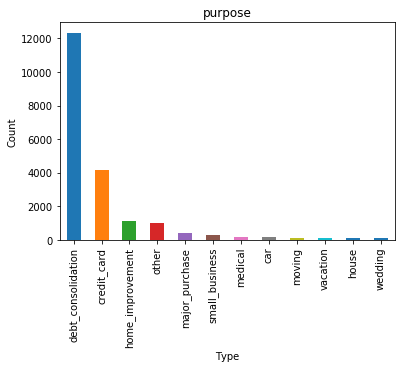

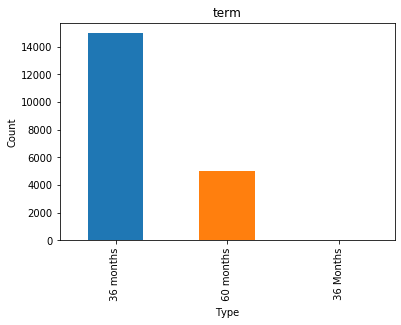

In [246]:
for col in data.select_dtypes(include=['object']).columns:
    data[col].value_counts().plot.bar()
    plt.xlabel('Type')
    plt.ylabel('Count')
    #plt.grid(b=None)
    plt.title(col)
    plt.show()

We have a typo in the 36 months. Let's fix it so we have the terms proper organized

In [247]:
data.term = data.term.str.lower()

In [248]:
data.term.value_counts()

 36 months    15001
 60 months     4999
Name: term, dtype: int64

Text(0, 0.5, 'total_rec_late_fee')

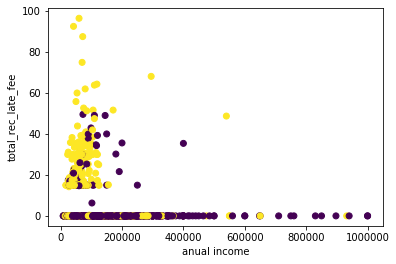

In [249]:
plt.scatter(data.annual_inc, data.total_rec_late_fee, c=data.bad_loan)
plt.xlabel('anual income')
plt.ylabel('total_rec_late_fee')

We can see that most late fees (especially the high ones) happen in indivuduals with lower income and the tendency to default happens there

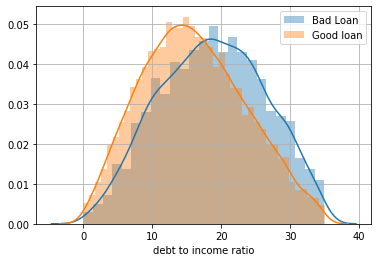

In [250]:
sns.distplot(data.dti[data.bad_loan == 1], label='Bad Loan')
sns.distplot(data.dti[data.bad_loan == 0], label='Good loan')
plt.xlabel('debt to income ratio')
plt.grid()
plt.legend()
plt.show()

This is the distribution of dti by target

Let's now see the missing values in percentage of observations

In [251]:
data.isnull().mean()*100

id                        0.000
grade                     0.000
annual_inc                0.000
short_emp                 0.000
emp_length_num            0.000
home_ownership            7.455
dti                       0.770
purpose                   0.000
term                      0.000
last_delinq_none          0.000
last_major_derog_none    97.130
revol_util                0.000
total_rec_late_fee        0.000
od_ratio                  0.000
bad_loan                  0.000
dtype: float64

Quick overview:

The *last_major_derog_none* feature is full of missing values, the best thing to do is just delete the feature. We also have some missing values in home_ownership and Debt-to-Income ratio. We can either input with mean/median or just delete the missing value observations - given that it's a low percentage of missing values in both features. 

Our target feature has imbalanced data - way more good loans than bad ones - as you would expect from a (non-insolvent) bank. I also noticed a problem in the "term" feature.

We have an ID column which is probable not helpfull. Even if the ID varies with time and consequentely it could vary with economic cycle etc, we have no business understanding to be able to use that information (and the results of past economic cycles would only be helpfull if we knew in what economic/business cycle the next loans would be granted to some individual. )

In [252]:
data.drop("last_major_derog_none", axis=1, inplace=True)

Overview of correlations between features

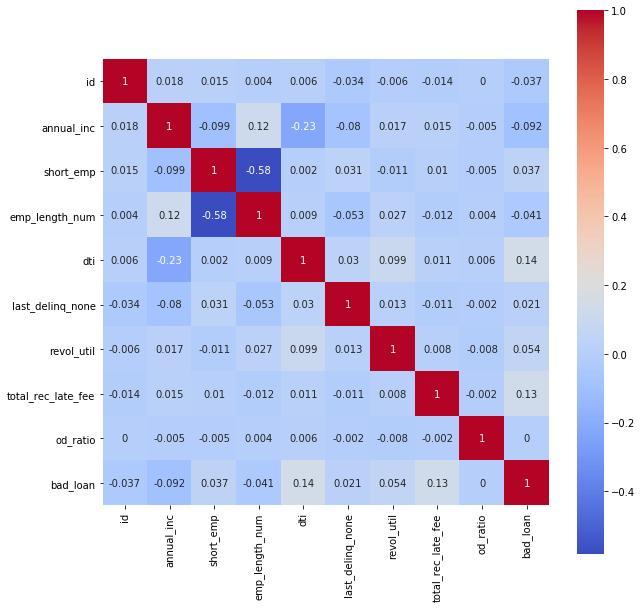

In [253]:
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(data.corr().round(3), 
            annot=True, 
            cmap='coolwarm', 
            square=True,
            ax=ax);

In [254]:
data_numeric = data.select_dtypes(exclude=['object','category'])
data_numeric.corr(method='spearman')['bad_loan'].abs().sort_values(ascending=False)

bad_loan              1.000000
total_rec_late_fee    0.141406
dti                   0.140378
annual_inc            0.130561
revol_util            0.099935
id                    0.043422
emp_length_num        0.041795
short_emp             0.037186
last_delinq_none      0.021494
od_ratio              0.000408
Name: bad_loan, dtype: float64

In [255]:
#for col in data_numeric.columns:
    #print(col)
 #   corr, pval = scipy.stats.spearmanr(data[col], data.bad_loan)
  #  print(f"{col} has a correlation of {corr:6.2%} (p-value: {pval:.4f}) \n")

In [256]:
data_numeric.corr(method='pearson')["bad_loan"].abs().sort_values(ascending=False)

bad_loan              1.000000
dti                   0.141884
total_rec_late_fee    0.130233
annual_inc            0.092402
revol_util            0.053682
emp_length_num        0.041420
id                    0.037307
short_emp             0.037186
last_delinq_none      0.021494
od_ratio              0.000403
Name: bad_loan, dtype: float64

In [257]:
data.drop("id", axis=1, inplace=True)

Let's examime our data again (next for the non-binary variables we'll boxplot to better look at the distribution of the values)

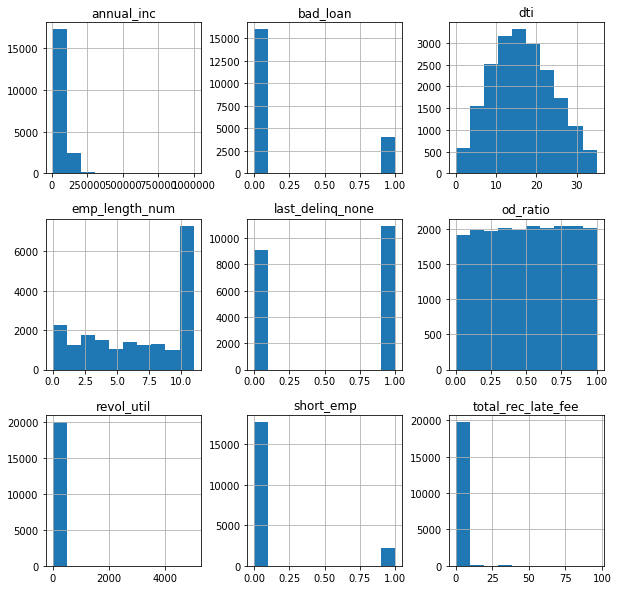

In [258]:
data.hist(figsize = (10,10));

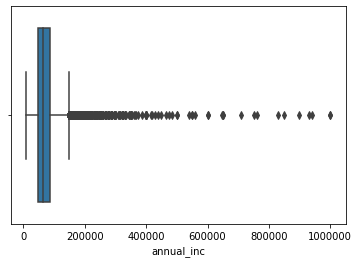

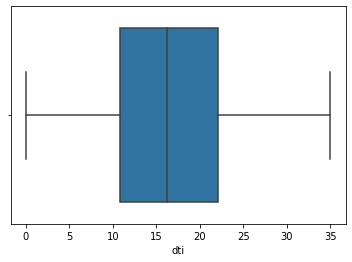

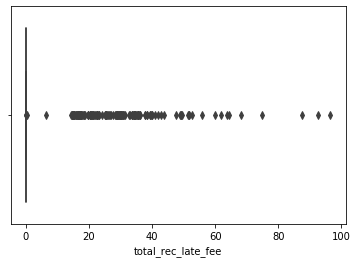

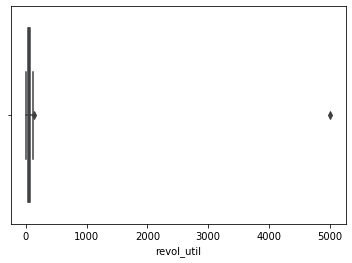

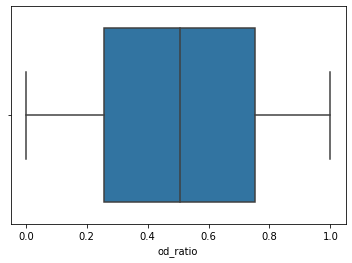

In [259]:
for col in data[["annual_inc", "dti", "total_rec_late_fee", "revol_util", "od_ratio"]].columns:
    sns.boxplot(data[col])
    plt.show()

We have definetly outlier(s) in the revol_util feature. And revol_util it's a ratio ( debt-to-limit ) so it's probably an error. 

In [260]:
data = data[data.revol_util < 1000]

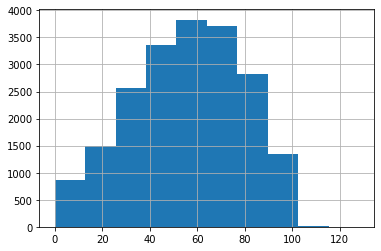

In [261]:
data.revol_util.hist()

`Revol_util` looks ok, let's try to gain some insight in debt to income aka `dti`

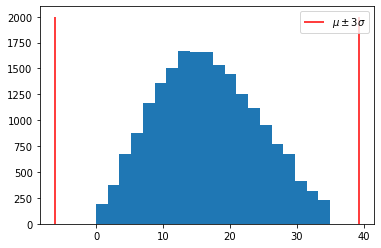

In [262]:
data_mean = data.dti.mean()
data_std = data.dti.std()

plt.hist(data.dti, bins=20)
plt.vlines(
    [data_mean - 3 * data_std, data_mean + 3 * data_std],
    ymin=0, ymax=2000,
    label="$\mu \pm 3 \sigma$",
    colors="r"
)

plt.legend(loc="upper right")
plt.show()

In [263]:
def mask_std(x, n):
    
    mean = x.mean()
    std = x.std()
    return (x < mean - n * std) | (x > mean + n * std)

In [264]:
for n in (2, 3):
    print(
        f"  {n} std:",
        mask_std(data.dti, n).sum(),
        "potential outliers"
    )

  2 std: 638 potential outliers
  3 std: 0 potential outliers


Let's look againt into missing values 

In [265]:
data.isna().sum()/len(data)*100

grade                 0.000000
annual_inc            0.000000
short_emp             0.000000
emp_length_num        0.000000
home_ownership        7.455373
dti                   0.770039
purpose               0.000000
term                  0.000000
last_delinq_none      0.000000
revol_util            0.000000
total_rec_late_fee    0.000000
od_ratio              0.000000
bad_loan              0.000000
dtype: float64

I'll fill the dti and delete the home_ownership info. Don't want to mess the data set by filling calues into a categorical feature with only 3 options

In [266]:
data.dti.fillna(data.dti.mean(),inplace=True)

In [267]:
data.dropna(inplace=True)

In [268]:
data.isna().sum()

grade                 0
annual_inc            0
short_emp             0
emp_length_num        0
home_ownership        0
dti                   0
purpose               0
term                  0
last_delinq_none      0
revol_util            0
total_rec_late_fee    0
od_ratio              0
bad_loan              0
dtype: int64

In [269]:
data_numeric = data.select_dtypes(include=np.number)

In [270]:
from sklearn.feature_selection import VarianceThreshold

var_th = VarianceThreshold(threshold=0.1)
var_th.fit_transform(data_numeric)

array([[1.000e+05, 1.000e+00, 2.627e+01, ..., 4.320e+01, 0.000e+00,
        0.000e+00],
       [8.300e+04, 4.000e+00, 5.390e+00, ..., 2.150e+01, 0.000e+00,
        0.000e+00],
       [7.800e+04, 1.100e+01, 1.845e+01, ..., 4.630e+01, 0.000e+00,
        1.000e+00],
       ...,
       [1.040e+05, 5.000e+00, 1.327e+01, ..., 7.850e+01, 0.000e+00,
        0.000e+00],
       [3.840e+04, 2.000e+00, 1.284e+01, ..., 4.740e+01, 0.000e+00,
        0.000e+00],
       [1.500e+05, 1.100e+01, 2.200e+00, ..., 4.070e+01, 0.000e+00,
        0.000e+00]])

In [271]:
var_th.get_support()

array([ True, False,  True,  True,  True,  True,  True, False,  True])

In [272]:
data_numeric.columns

Index(['annual_inc', 'short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'revol_util', 'total_rec_late_fee', 'od_ratio', 'bad_loan'],
      dtype='object')

In [273]:
for col in data_numeric.columns:
    corr, pval = scipy.stats.pearsonr(data_numeric[col], data_numeric.bad_loan)
    print(col, f"corr: {corr:.2%} (p-value: {pval:.3f})")

annual_inc corr: -9.30% (p-value: 0.000)
short_emp corr: 3.87% (p-value: 0.000)
emp_length_num corr: -4.27% (p-value: 0.000)
dti corr: 14.19% (p-value: 0.000)
last_delinq_none corr: 2.20% (p-value: 0.003)
revol_util corr: 9.93% (p-value: 0.000)
total_rec_late_fee corr: 12.85% (p-value: 0.000)
od_ratio corr: -0.10% (p-value: 0.891)
bad_loan corr: 100.00% (p-value: 0.000)


The features `short_emp` and `od_ratio` appear to be the feaures with low information to our target

Let's test the categorical features for independence

In [274]:
data_cat = data.select_dtypes(include=['object'])

In [275]:
for col in data_cat.columns:
    table = pd.crosstab(data_cat[col], data.bad_loan)
    #print(table)
    display(table)
    _, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    print(f"with a p-value: {pval:.3f}")

bad_loan,0,1
grade,,
A,1871,115
B,4873,714
C,4083,1084
D,2362,897
E,1028,508
F,489,327
G,94,63


with a p-value: 0.000


bad_loan,0,1
home_ownership,,
MORTGAGE,8135,1708
OWN,1297,316
RENT,5368,1684


with a p-value: 0.000


bad_loan,0,1
purpose,,
car,128,28
credit_card,3192,649
debt_consolidation,9095,2300
home_improvement,827,191
house,81,14
major_purchase,268,85
medical,127,34
moving,87,28
other,693,254


with a p-value: 0.000


bad_loan,0,1
term,,
36 months,11513,2338
60 months,3287,1370


with a p-value: 0.000


It appears all categorical features have revelant information about our target  

Let's now encode the categorical variables. Grade is a scale so I'll just map to numbers. To the other three, since they are not too many, let's go for OHE

In [276]:
data.grade = data.grade.map(
    {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7}
)

In [277]:
data = pd.get_dummies(data, columns = ["term","home_ownership","purpose"])
data.head()

,grade,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
0,1,100000.0,1,1,26.27,1,43.2,0.0,0.160624,0,...,0,0,0,0,0,0,0,0,0,0
1,1,83000.0,0,4,5.39,0,21.5,0.0,0.810777,0,...,0,0,0,0,0,0,0,0,0,0
2,4,78000.0,0,11,18.45,1,46.3,0.0,0.035147,1,...,1,0,0,0,0,0,0,0,0,0
3,4,37536.0,0,6,12.28,0,10.7,0.0,0.534887,1,...,0,0,0,0,1,0,0,0,0,0
4,4,65000.0,0,11,11.26,0,15.2,0.0,0.166500,0,...,1,0,0,0,0,0,0,0,0,0


In [278]:
data.bad_loan.value_counts()/len(data.bad_loan)*100

0    79.96542
1    20.03458
Name: bad_loan, dtype: float64

Given that we have imbalanced data we'll use AUC ROC to evaluate the models

Let's split the data into train/test

In [279]:
random = 10

In [280]:
train_set, test_set = train_test_split(data, test_size = 0.2, random_state=random)

In [281]:
X_train = train_set.drop(['bad_loan'], axis = 1)
y_train = train_set['bad_loan']

X_test = test_set.drop(['bad_loan'], axis = 1)
y_test = test_set['bad_loan']

In [282]:
scaler = MinMaxScaler()

features_names = X_train.columns

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = features_names)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = features_names)

### Logistic Regression

In [283]:
lr = LogisticRegression(random_state = random, max_iter = 1000).fit(X_train, y_train)

In [290]:
parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000]}

In [291]:
clf = GridSearchCV(lr, parameters, cv = 5).fit(X_train, y_train)

In [292]:
y_preds = clf.predict(X_test)

In [293]:
roc_auc_score(y_test, y_preds)

0.5339367714588485

In [294]:
confusion_matrix_lr = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix_lr

Predicted,0,1,All
Actual,,,
0,2947,33,2980
1,665,57,722
All,3612,90,3702


### KNN

In [295]:
knn = KNeighborsClassifier()

In [296]:
parameters = {'n_neighbors': range(1, 30, 1)}

In [297]:
clf = GridSearchCV(knn, parameters, cv = 5).fit(X_train, y_train)

In [298]:
y_preds = clf.predict(X_test)
#accuracy_score(y_test, y_preds)

In [299]:
roc_auc_score(y_test, y_preds)

0.5068857015374891

In [300]:
confusion_matrix = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix

Predicted,0,1,All
Actual,,,
0,2955,25,2980
1,706,16,722
All,3661,41,3702


## SVM

In [301]:
clf_svm = SVC(random_state = random).fit(X_train, y_train)

In [302]:
y_preds = clf_svm.predict(X_test)

In [303]:
roc_auc_score(y_test, y_preds)

0.5055401662049861

In [304]:
confusion_matrix = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)
confusion_matrix

Predicted,0,1,All
Actual,,,
0,2980,0,2980
1,714,8,722
All,3694,8,3702


## Decison Tree

In [327]:
clf_tree = tree.DecisionTreeClassifier(random_state = random)

parameters = {'max_depth': [4, 6, 8], 'min_samples_split': [2, 4, 10]}

clf = GridSearchCV(clf_tree, parameters, cv = 5).fit(X_train, y_train)

In [328]:
y_preds = clf.predict(X_test)

In [330]:
roc_auc_score(y_test, y_preds)

0.5223712097268958

In [331]:
confusion_matrix = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

In [332]:
confusion_matrix

Predicted,0,1,All
Actual,,,
0,2973,7,2980
1,688,34,722
All,3661,41,3702


## Random Forest

In [333]:
clf_tree = RandomForestClassifier(random_state = random)

parameters = {'n_estimators': [10, 100, 300]}

clf = GridSearchCV(clf_tree, parameters, cv = 5).fit(X_train, y_train)

In [334]:
y_preds = clf.predict(X_test)

In [335]:
roc_auc_score(y_test, y_preds)

0.5425430850173828

In [336]:
confusion_matrix = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

In [338]:
confusion_matrix

Predicted,0,1,All
Actual,,,
0,2924,56,2980
1,647,75,722
All,3571,131,3702


## Neural Network

In [342]:
mlp = MLPClassifier(random_state = random, max_iter = 2000)

parameters = {'hidden_layer_sizes': [(13), (13, 8), (13, 8, 2)], 'learning_rate_init': [0.00001, 0.001, 0.01, 0.1, 1]}

clf_mlp = GridSearchCV(mlp, parameters, cv = 5).fit(X_train, y_train)

In [343]:
y_preds = clf_mlp.predict(X_test)

In [344]:
roc_auc_score(y_test, y_preds)

0.5398552678056852

In [345]:
confusion_matrix = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins = True)

In [346]:
confusion_matrix

Predicted,0,1,All
Actual,,,
0,2941,39,2980
1,655,67,722
All,3596,106,3702


All models are only slighlty above 50 with Random forest being the best performing model. 
With more business information we would be able to better analyse the best optimization of **False Positives** and **False Negatives**


_________

________